# ML for CS Project: Malware Detection netML Leaderboard Result Reproduction

**Team:** Rhea Madhogarhia, Anushka Agarwal, Rohan Madhogarhia

## Summary
The goal of this project is to determine whether we can train a model to detect malware flows in a network. Effective malware detection helps protect systems and users from security threats. We aim to reproduce and potentially improve upon the results of the netML malware detection leaderboard.

## Objectives
1.  **Data Analysis:** Understand the netML dataset and check for class imbalances.
2.  **Model Training:** Experiment with Random Forest, CatBoost, XGBoost, and KNN.
3.  **Evaluation:** Focus on Recall/Sensitivity to minimize false negatives (malware slipping through).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import pyshark

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, recall_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

try:
    import xgboost as xgb
    from xgboost import XGBClassifier
except ImportError:
    print("Skipping import.")

try:
    from catboost import CatBoostClassifier
except ImportError:
    print("Skipping import.")

# Set visualization style
sns.set(style="whitegrid")

## 1. Data Loading


Code to convert our netml dataset into a pandas dataframe

### 1a. Load data

- inspects Ethernet, IP, and UDP layers independently
    - adds fields only when present to avoid parsing errors
- fields: TTL, ports, lengths, checksums, options are extracted because they often encode behavioral patterns useful for traffic classification
- Raw payload bytes are truncated (max_raw_len) to prevent massive feature sizes and decoded with "replace" to ensure robustness when encountering binary data
- Missing layers default to None

In [ ]:
from scapy.all import PcapNgReader, Ether, IP, UDP
import pandas as pd

def packet_to_row(pkt, max_raw_len=120):
    row = {
        "timestamp": pkt.time,
        "pkt_len": len(pkt),
    }

    # --- Ethernet layer ---
    if Ether in pkt:
        eth = pkt[Ether]
        row.update({
            "eth_dst": eth.dst,
            "eth_src": eth.src,
            "eth_type": eth.type,
        })

    # --- IP layer ---
    if IP in pkt:
        ip = pkt[IP]
        row.update({
            "ip_version": ip.version,
            "ip_ihl": ip.ihl,
            "ip_tos": ip.tos,
            "ip_len": ip.len,
            "ip_id": ip.id,
            "ip_flags": int(ip.flags),  # make flags numeric
            "ip_frag": ip.frag,
            "ip_ttl": ip.ttl,
            "ip_proto": ip.proto,
            "ip_chksum": ip.chksum,
            "ip_src": ip.src,
            "ip_dst": ip.dst,
            "ip_options_len": len(ip.options) if ip.options is not None else 0,
        })

    # --- UDP layer ---
    if UDP in pkt:
        udp = pkt[UDP]
        row.update({
            "l4_proto": "UDP",
            "udp_sport": udp.sport,
            "udp_dport": udp.dport,
            "udp_len": udp.len,
            "udp_chksum": udp.chksum,
        })
    else:
        row["l4_proto"] = None

    if pkt.haslayer("Raw"):
        raw = pkt["Raw"].load
        truncated = raw[:max_raw_len]
        try:
            row["raw_load"] = truncated.decode("utf-8", errors="replace")
        except Exception:
            row["raw_load"] = repr(truncated)
    else:
        row["raw_load"] = None

    return row

rows = []
with PcapNgReader("data/traffic.pcapng") as pcap_reader:
    for pkt in pcap_reader:
        rows.append(packet_to_row(pkt))

df = pd.DataFrame(rows)
df.head()


,timestamp,pkt_len,eth_dst,eth_src,eth_type,ip_version,ip_ihl,ip_tos,ip_len,ip_id,...,ip_chksum,ip_src,ip_dst,ip_options_len,l4_proto,udp_sport,udp_dport,udp_len,udp_chksum,raw_load
0,2419462452.933651,217,01:00:5e:7f:ff:fa,a4:5e:60:dd:58:1d,2048,4,5,0,203,64595,...,2757,192.168.1.103,239.255.255.250,0,UDP,54812.0,1900.0,183.0,36797.0,M-SEARCH * HTTP/1.1\r\nHOST: 239.255.255.250:1...
1,2419466747.912463,217,01:00:5e:7f:ff:fa,a4:5e:60:dd:58:1d,2048,4,5,0,203,37500,...,29852,192.168.1.103,239.255.255.250,0,UDP,54812.0,1900.0,183.0,36797.0,M-SEARCH * HTTP/1.1\r\nHOST: 239.255.255.250:1...
2,2419471042.882392,217,01:00:5e:7f:ff:fa,a4:5e:60:dd:58:1d,2048,4,5,0,203,51748,...,15604,192.168.1.103,239.255.255.250,0,UDP,54812.0,1900.0,183.0,36797.0,M-SEARCH * HTTP/1.1\r\nHOST: 239.255.255.250:1...
3,2419475337.90648,217,01:00:5e:7f:ff:fa,a4:5e:60:dd:58:1d,2048,4,5,0,203,39014,...,28338,192.168.1.103,239.255.255.250,0,UDP,54812.0,1900.0,183.0,36797.0,M-SEARCH * HTTP/1.1\r\nHOST: 239.255.255.250:1...
4,894306680.3797,216,01:00:5e:7f:ff:fa,c0:38:96:11:73:e5,2048,4,5,0,202,10258,...,57038,192.168.1.160,239.255.255.250,0,UDP,54334.0,1900.0,182.0,27627.0,M-SEARCH * HTTP/1.1\r\nHOST: 239.255.255.250:1...


### 1b. get features

- convert raw timestamps into datetimes
    - frequency, burst behavior, and timing irregularities can be indicators of malware
- payload_len and raw_len quantify how much data is carried in each packet
    - malware often sends small periodic payloads, encrypted blobs, or unusually structured payloads
- Using sport, dport, and service flags (DNS/HTTP/HTTPS/SSDP) helps identify whether packets align with standard service protocols or suspicious/rare port usage
    - Malware frequently abuses uncommon high ports, mimics common ones incorrectly, or communicates over nonstandard UDP traffic
- Categorize source/dest IPs as private, external, or multicast—and also direction
    - captures whether packets represent outbound communication, inbound probing, or lateral movement within a local network, a strong separator between benign and malicious flows
- Packet TTL provides a rough estimate of hop count
    - malware often uses abnormal TTLs (either too low or too uniform). 
- pkt_size helps detect repetitive beacon patterns or unusual fixed-size messages common in botnet traffic.
- payload_mostly_ascii flags whether the payload resembles human-readable text—much benign traffic does, while malware often uses binary or encrypted payloads
- payload_contains_http helps catch malware that pretends to be HTTP but fails to fully emulate browser-like traffic.

In [ ]:
df.shape
df.columns

import numpy as np
import pandas as pd
import ipaddress

def is_private_ip(ip):
    try:
        return ipaddress.ip_address(ip).is_private
    except Exception:
        return np.nan

def is_multicast_ip(ip):
    try:
        return ipaddress.ip_address(ip).is_multicast
    except Exception:
        return np.nan

def add_packet_features(df):
    df = df.copy()

    if not np.issubdtype(df['timestamp'].dtype, np.datetime64):
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', errors='ignore')

    # UDP header=8 bytes
    # payload_len >= 0
    df['payload_len'] = np.where(df['udp_len'].notna(),
                                 np.maximum(df['udp_len'] - 8, 0),
                                 np.nan)

    # raw payload length (works whether it's bytes or str; NaN -> 0)
    df['raw_len'] = df['raw_load'].apply(
        lambda x: len(x) if isinstance(x, (bytes, bytearray, str)) else 0
    )
    # use udp_dport as generic dport since dataset is UDP
    df['dport'] = df['udp_dport']
    df['sport'] = df['udp_sport']

    df['dport_is_well_known'] = df['dport'] < 1024
    df['dport_is_high'] = df['dport'] >= 1024

    common_ports = {
        53: 'dns',
        80: 'http',
        443: 'https',
        22: 'ssh',
        123: 'ntp',
        1900: 'ssdp',
    }
    df['dport_service'] = df['dport'].map(common_ports).fillna('other')

    df['is_dns'] = (df['dport'] == 53)
    df['is_http'] = (df['dport'] == 80)
    df['is_https'] = (df['dport'] == 443)
    df['is_ssdp'] = (df['dport'] == 1900)

    df['ip_src_private'] = df['ip_src'].apply(is_private_ip)
    df['ip_dst_private'] = df['ip_dst'].apply(is_private_ip)
    df['ip_src_multicast'] = df['ip_src'].apply(is_multicast_ip)
    df['ip_dst_multicast'] = df['ip_dst'].apply(is_multicast_ip)

    
    def flow_direction(row):
        sp = row['ip_src_private']
        dp = row['ip_dst_private']
        if sp and not dp:
            return 'internal_to_external'
        elif not sp and dp:
            return 'external_to_internal'
        elif sp and dp:
            return 'internal_to_internal'
        elif not sp and not dp:
            return 'external_to_external'
        return 'unknown'

    df['direction'] = df.apply(flow_direction, axis=1)

    df['ttl'] = df['ip_ttl']
    df['ttl_is_low'] = df['ttl'] <= 5  # good for detecting local/multicast
    df['pkt_size'] = df['pkt_len']

    def is_mostly_ascii(x):
        if isinstance(x, (bytes, bytearray)):
            b = x
        elif isinstance(x, str):
            b = x.encode('utf-8', errors='ignore')
        else:
            return False
        if len(b) == 0:
            return False
        printable = sum(32 <= c < 127 for c in b)
        return printable / len(b) > 0.8

    df['payload_mostly_ascii'] = df['raw_load'].apply(is_mostly_ascii)

    df['payload_contains_http'] = df['raw_load'].apply(
        lambda x: ('HTTP/' in x if isinstance(x, str) else
                   (b'HTTP/' in x if isinstance(x, (bytes, bytearray)) else False))
    )

    return df

df_features = add_packet_features(df)
df_features.head()


# extract features

/var/folders/zx/5gx8nw1j6bg4lvdv3ws19cnh0000gn/T/ipykernel_74153/537814996.py:25: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', errors='ignore')


,timestamp,pkt_len,eth_dst,eth_src,eth_type,ip_version,ip_ihl,ip_tos,ip_len,ip_id,...,ip_src_private,ip_dst_private,ip_src_multicast,ip_dst_multicast,direction,ttl,ttl_is_low,pkt_size,payload_mostly_ascii,payload_contains_http
0,None,217,01:00:5e:7f:ff:fa,a4:5e:60:dd:58:1d,2048,4,5,0,203,64595,...,True,False,False,True,internal_to_external,1,True,217,True,True
1,None,217,01:00:5e:7f:ff:fa,a4:5e:60:dd:58:1d,2048,4,5,0,203,37500,...,True,False,False,True,internal_to_external,1,True,217,True,True
2,None,217,01:00:5e:7f:ff:fa,a4:5e:60:dd:58:1d,2048,4,5,0,203,51748,...,True,False,False,True,internal_to_external,1,True,217,True,True
3,None,217,01:00:5e:7f:ff:fa,a4:5e:60:dd:58:1d,2048,4,5,0,203,39014,...,True,False,False,True,internal_to_external,1,True,217,True,True
4,None,216,01:00:5e:7f:ff:fa,c0:38:96:11:73:e5,2048,4,5,0,202,10258,...,True,False,False,True,internal_to_external,1,True,216,True,True


### 1c. Get labels

reading the embedded labels in the dataset

In [ ]:
import subprocess
import io
import pandas as pd

pcap_path = "data/traffic.pcapng"

cmd = [
    "tshark",
    "-r", pcap_path,
    "-T", "fields",
    "-e", "frame.number",
    "-e", "frame.comment",
    "-E", "header=y",
    "-E", "separator=\t", 
]

result = subprocess.run(cmd, capture_output=True, text=True, check=True)
print(result.stdout.splitlines()[:5])

df_comments = pd.read_csv(io.StringIO(result.stdout), sep="\t")
df_comments.head()


['frame.number\tframe.comment', '1\t4740404938944317776,malware_pua', '2\t4740404938944317776,malware_pua', '3\t4740404938944317776,malware_pua', '4\t4740404938944317776,malware_pua']


,frame.number,frame.comment
0,1,"4740404938944317776,malware_pua"
1,2,"4740404938944317776,malware_pua"
2,3,"4740404938944317776,malware_pua"
3,4,"4740404938944317776,malware_pua"
4,5,"8131368769381413716,malware_pua"


In [ ]:
#nmake names nicer
df_comments = df_comments.rename(columns={
    "frame.number": "frame_no",
    "frame.comment": "comment",
})

df_comments["comment"] = df_comments["comment"].astype(str).str.replace(r"\\,", ",", regex=True)

#split "sampleID,easy_hard"
parts = df_comments["comment"].str.split(",", n=1, expand=True)
df_comments["sample_id"] = parts[0]
df_comments["label_combined"] = parts[1]

#easy_hard -> easy, hard
easy_hard = df_comments["label_combined"].str.split("_", n=1, expand=True)
df_comments["easy_label"] = easy_hard[0]   # malware / benign
df_comments["hard_label"] = easy_hard[1]   # pua, mirai, etc.

#spelling error in  dataset
df_comments["easy_label"] = df_comments["easy_label"].replace({
    "bengin": "benign"
})


df_comments.head()


,frame_no,comment,sample_id,label_combined,easy_label,hard_label
0,1,"4740404938944317776,malware_pua",4740404938944317776,malware_pua,malware,pua
1,2,"4740404938944317776,malware_pua",4740404938944317776,malware_pua,malware,pua
2,3,"4740404938944317776,malware_pua",4740404938944317776,malware_pua,malware,pua
3,4,"4740404938944317776,malware_pua",4740404938944317776,malware_pua,malware,pua
4,5,"8131368769381413716,malware_pua",8131368769381413716,malware_pua,malware,pua


In [6]:
print(df_comments.shape)
print(df_features.shape)
print(df_comments["easy_label"].unique())
print(df_comments["hard_label"].unique())
df_comments["easy_label"].value_counts()


(5897362, 6)
(5897362, 45)
['malware' 'benign']
['pua' 'benign' 'htbot' 'magichound' 'downware' 'ursnif' 'emotet' 'ramnit'
 'tinba' 'cobalt' 'minertrojan' 'trickster' 'dridex' 'adload' 'benign7'
 'ccleaner' 'bitcoinminer' 'trickbot' 'trojandownloader' 'artemis']


easy_label
malware    3386409
benign     2510953
Name: count, dtype: int64

### 1d. Join Features with Labels

In [ ]:
df_features = df_features.copy()
df_features["frame_no"] = np.arange(1, len(df_features) + 1)

df_merged = df_features.merge(
    df_comments[["frame_no", "sample_id", "easy_label", "hard_label"]],
    on="frame_no",
    how="left"
)

print((df_merged["frame_no"] == df_features["frame_no"]).all())
df_merged.head()



True


,timestamp,pkt_len,eth_dst,eth_src,eth_type,ip_version,ip_ihl,ip_tos,ip_len,ip_id,...,direction,ttl,ttl_is_low,pkt_size,payload_mostly_ascii,payload_contains_http,frame_no,sample_id,easy_label,hard_label
0,None,217,01:00:5e:7f:ff:fa,a4:5e:60:dd:58:1d,2048,4,5,0,203,64595,...,internal_to_external,1,True,217,True,True,1,4740404938944317776,malware,pua
1,None,217,01:00:5e:7f:ff:fa,a4:5e:60:dd:58:1d,2048,4,5,0,203,37500,...,internal_to_external,1,True,217,True,True,2,4740404938944317776,malware,pua
2,None,217,01:00:5e:7f:ff:fa,a4:5e:60:dd:58:1d,2048,4,5,0,203,51748,...,internal_to_external,1,True,217,True,True,3,4740404938944317776,malware,pua
3,None,217,01:00:5e:7f:ff:fa,a4:5e:60:dd:58:1d,2048,4,5,0,203,39014,...,internal_to_external,1,True,217,True,True,4,4740404938944317776,malware,pua
4,None,216,01:00:5e:7f:ff:fa,c0:38:96:11:73:e5,2048,4,5,0,202,10258,...,internal_to_external,1,True,216,True,True,5,8131368769381413716,malware,pua


## 2. Exploratory Data Analysis (EDA)

**Feedback from proposal :** chase's feedback indicated the importance of checking for class imbalance, as malware data is often uneven (mostly benign traffic, very little malware).

We will visualize the distribution of labels here.

easy_label
malware    3386409
benign     2510953
Name: count, dtype: int64


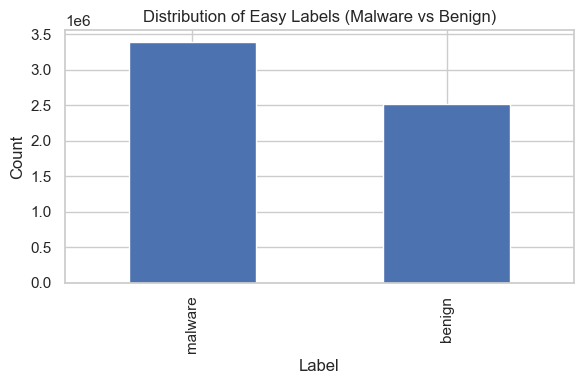

In [8]:
import matplotlib.pyplot as plt

label_counts = df_merged["easy_label"].value_counts()

print(label_counts)

plt.figure(figsize=(6,4))
label_counts.plot(kind="bar")
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Distribution of Easy Labels (Malware vs Benign)")
plt.tight_layout()
plt.show()


- The dataset is relatively balanced between malware and benign traffic, unlike real-world networks where malware is extremely rare.
- This is  beneficial for training because it forces the model to learn meaningful malware patterns instead of defaulting to predicting benign for everything
- This could affect real world performance: performance metrics computed under a malware-heavy distribution will look more optimistic than what would occur in production.
    - In a real deployment, extremely low malware prevalence could mean that small false-positive rates can generate large numbers of misclassifications and accuracy becomes an unreliable metric.

## 3. Model Training

### Split Data

Select Features + Target

- We keep only the columns that are already numbers because the models work best with clean numeric data
- drop ID-like columns (frame_no, sample_id):
    - These columns act like packet or sample identifiers, not real features. If we kept them, the model might cheat by learning that certain IDs always belong to malware or benign traffic, which would give unrealistically high accuracy
- We group by sample_id so that all packets from the same sample stay together in either the training set or the test set. This prevents the model from seeing very similar packets in both sets, which would again make the results misleading.

In [ ]:
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit

#numeric feature columns only
numeric_cols = df_merged.select_dtypes(
    include=["int64", "float64", "int32", "float32"]
).columns

#drop id-ish columns
drop_cols = ["frame_no", "sample_id"]
feature_cols = [c for c in numeric_cols if c not in drop_cols]

#features and labels
X = df_merged[feature_cols]
y = df_merged["easy_label"]
groups = df_merged["sample_id"]  # used to avoid flow leakage

#group-wise train/test split so no sample_id appears in both
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

models = {}

X_train.shape, X_test.shape


((4715795, 23), (1181567, 23))

In [ ]:
# checking for leakage oops
"hard_label" in X_test.columns

False

### RandomForest 

Baseline Random Forest (handles imbalance automatically)

- dataset doesn’t have a perfect 50/50 split between malware and benign packets
- tells RF to treat both classes as equally important, even if one appears more often in the training data.
- prevents the model from just predicting the majority class (malware) most of the time

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    n_jobs=-1,
    class_weight="balanced"
)

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

models["Random Forest"] = rf

print("Random Forest Results:")
print(classification_report(y_test, rf_pred))

Random Forest Results:
              precision    recall  f1-score   support

      benign       0.98      0.97      0.98    504492
     malware       0.98      0.99      0.98    677075

    accuracy                           0.98   1181567
   macro avg       0.98      0.98      0.98   1181567
weighted avg       0.98      0.98      0.98   1181567



### XGboost

handles imbalance via scale_pos_weight  
Computes the balancing weight

- since malware appears more often than benign in the training data scale_pos_weight = benign_count / malware_count will produce a value less than 1.
- this tells the xgboost to pay more attention to correctly identifying benign packets
- this avoids the problem where the model labels everything as malware because malware dominates the dataset


In [ ]:
#compute balancing weight
malware_count = (y_train == "malware").sum()
benign_count = (y_train == "benign").sum()

scale_pos_weight = benign_count / malware_count
print(scale_pos_weight)

# Training
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.8,
    objective="binary:logistic",
    scale_pos_weight=scale_pos_weight,
    tree_method="hist",
    n_jobs=-1
)

xgb.fit(X_train, (y_train == "malware").astype(int))
xgb_pred = xgb.predict(X_test)

models["XGboost"] = xgb

print("XGBoost Results:")
print(classification_report((y_test == "malware").astype(int), xgb_pred))


0.7405735136384071
XGBoost Results:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92    504492
           1       0.94      0.94      0.94    677075

    accuracy                           0.93   1181567
   macro avg       0.93      0.93      0.93   1181567
weighted avg       0.93      0.93      0.93   1181567



### CatBoost 
works well with categorical + imbalance
Requires minimal preprocessing

- Using class_weights to handle imbalance
- [1, malware_count / benign_count] where the second value is the weight for the malware class
- since malware is more common than benign, the ratio is < 1 telling CatBoost to pay more attention to the benign class
    - again ensures the model doesn’t get biased toward the majority class

In [13]:
from catboost import CatBoostClassifier

cat = CatBoostClassifier(
    iterations=500,
    depth=8,
    learning_rate=0.05,
    loss_function="Logloss",
    verbose=False,
    class_weights=[1, malware_count / benign_count]
)

cat.fit(X_train, y_train)
cat_pred = cat.predict(X_test)

models["CatBoost"] = cat

print("CatBoost Results:")
print(classification_report(y_test, cat_pred))

CatBoost Results:
              precision    recall  f1-score   support

      benign       0.98      0.81      0.89    504492
     malware       0.87      0.99      0.93    677075

    accuracy                           0.91   1181567
   macro avg       0.93      0.90      0.91   1181567
weighted avg       0.92      0.91      0.91   1181567



## 4. Evaluation

### Metrics Focus: Recall/Sensitivity
from our proposal "It is more prudent and valuable to stop all malware attacks than it is to ensure we don’t get false positives."* 

Therefore, we look closely at Recall for the Malware class.

In [ ]:
#checking for overlap
train_ids = set(df_merged.iloc[train_idx]["sample_id"])
test_ids  = set(df_merged.iloc[test_idx]["sample_id"])

print("Overlap:", train_ids & test_ids)  # should be empty
print("Train samples:", len(train_ids), " Test samples:", len(test_ids))

Overlap: set()
Train samples: 398756  Test samples: 99690



--- Random Forest Results ---
              precision    recall  f1-score   support

      benign       0.98      0.97      0.98    504492
     malware       0.98      0.99      0.98    677075

    accuracy                           0.98   1181567
   macro avg       0.98      0.98      0.98   1181567
weighted avg       0.98      0.98      0.98   1181567



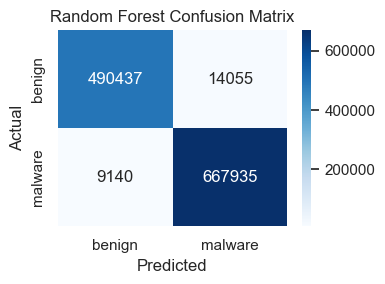


--- XGboost Results ---
              precision    recall  f1-score   support

      benign       0.92      0.91      0.92    504492
     malware       0.94      0.94      0.94    677075

    accuracy                           0.93   1181567
   macro avg       0.93      0.93      0.93   1181567
weighted avg       0.93      0.93      0.93   1181567



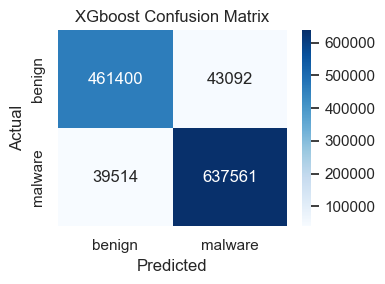


--- CatBoost Results ---
              precision    recall  f1-score   support

      benign       0.98      0.81      0.89    504492
     malware       0.87      0.99      0.93    677075

    accuracy                           0.91   1181567
   macro avg       0.93      0.90      0.91   1181567
weighted avg       0.92      0.91      0.91   1181567



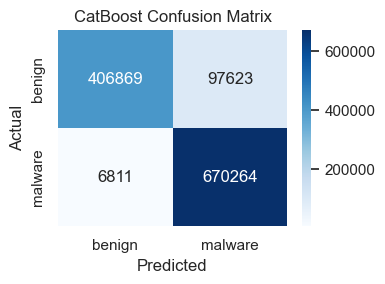

,Model,Accuracy,Recall (Malware)
2,CatBoost,0.911614,0.989941
0,Random Forest,0.980369,0.986501
1,XGboost,0.930088,0.941640


In [ ]:
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    classification_report,
    confusion_matrix,
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

results = []

# Explicit label order for reports & confusion matrices
label_order = ["benign", "malware"]

def normalize_preds(y_pred, y_true):
    """
    Ensure y_pred has the same label type/space as y_true.
    Here: y_true are strings ['benign','malware'], but some models
    may output 0/1. We map 0 -> 'benign', 1 -> 'malware' if needed.
    """
    # If y_true are strings and y_pred are ints {0,1}, map them
    if y_true.dtype == object and np.issubdtype(y_pred.dtype, np.integer):
        unique_pred = np.unique(y_pred)
        if set(unique_pred).issubset({0, 1}) and set(np.unique(y_true)) == {"benign", "malware"}:
            mapping = {0: "benign", 1: "malware"}
            y_pred = np.vectorize(mapping.get)(y_pred)
    return y_pred

for name, model in models.items():
    # predict
    y_pred = model.predict(X_test)
    # normalize
    y_pred = normalize_preds(np.array(y_pred), y_test.values)

    #overall accuracy
    acc = accuracy_score(y_test, y_pred)

    # recall specifically for the malware class
    rec_malware = recall_score(y_test, y_pred, pos_label="malware")

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Recall (Malware)": rec_malware,
    })

    print(f"\n{name} Results")
    print(classification_report(
        y_test,
        y_pred,
        labels=label_order,
        target_names=label_order,
        zero_division=0,   # avoid warnings when a class isn't predicted
    ))

    cm = confusion_matrix(y_test, y_pred, labels=label_order)

    plt.figure(figsize=(4, 3))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=label_order,
        yticklabels=label_order,
    )
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# summary table sorted by malware recall (our primary metric)
results_df = pd.DataFrame(results).sort_values(
    by="Recall (Malware)", ascending=False
)
results_df


### Analysis of Results:

- Random Forest does the best overall
    - Performance: High accuracy (0.98), high malware recall (0.986), and strong benign recall (0.97).
- XGBoost
    - Performance: Accuracy around 0.93, malware recall 0.94, and benign recall 0.91.
    - Slightly more aggressive toward predicting malware, likely due to imbalance and its boosting process, leading to more false positives than RF
- CatBoost (does the best in recall for malware)
    - Performance: Malware recall is extremely high (0.99), but benign recall is much lower (0.81), bringing down overall accuracy (0.91).
    - tends to overfit to malware characteristics, causing it to mislabel many benign packets
        - This may be useful if catching everything is the priority, which it is in our case

## 5. Feature Importance

Analyze which network features (from the netML dataset) contributed most to malware detection.


Top 15 features for Random Forest:


ip_flags       0.265966
ip_chksum      0.131340
ip_id          0.130495
ip_ttl         0.076160
ttl            0.075950
pkt_len        0.073449
pkt_size       0.068541
ip_len         0.059331
raw_len        0.036683
dport          0.017538
udp_dport      0.016696
udp_sport      0.013890
sport          0.013320
payload_len    0.007394
udp_len        0.006535
dtype: float64

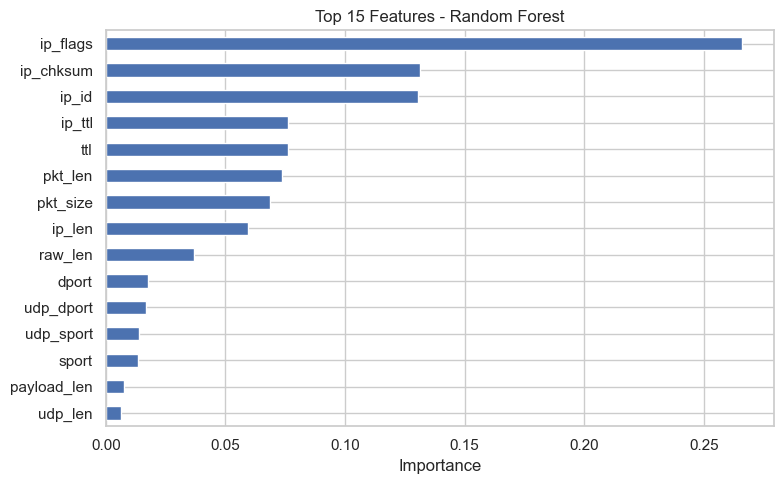


Top 15 features for XGboost:


ip_flags       0.748309
ip_ttl         0.070055
sport          0.036692
udp_len        0.029717
payload_len    0.029437
udp_sport      0.023210
udp_dport      0.019402
dport          0.011168
pkt_len        0.008152
ttl            0.007010
ip_len         0.004840
raw_len        0.004533
ip_proto       0.002484
pkt_size       0.001600
ip_id          0.001572
dtype: float32

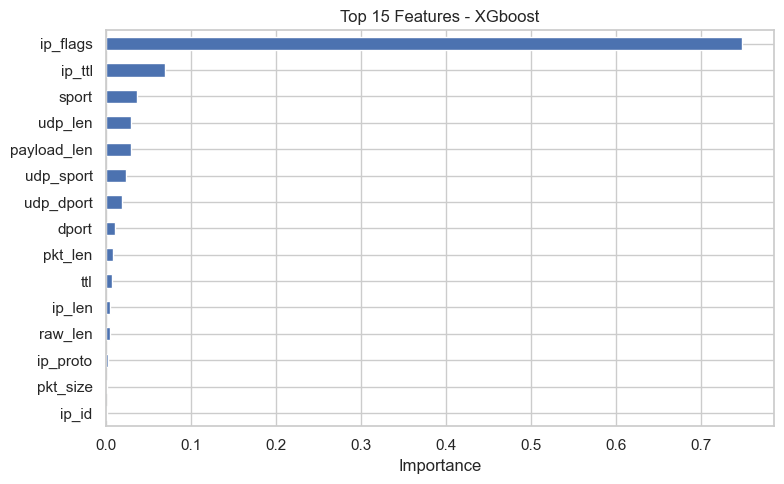


Top 15 features for CatBoost:


ip_flags       54.048844
raw_len         7.200014
ttl             6.688378
ip_ttl          6.007902
pkt_len         5.073404
udp_dport       5.035420
pkt_size        3.525758
ip_len          3.504573
dport           2.394299
ip_id           2.204771
ip_chksum       1.882486
udp_sport       0.832225
sport           0.601181
payload_len     0.482417
udp_len         0.359063
dtype: float64

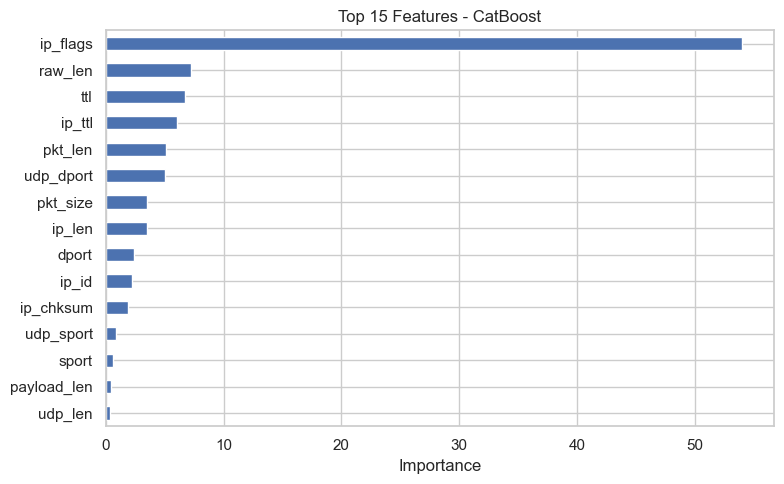

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

feature_names = X_train.columns

def plot_top_importances(model_name, importance_series, top_n=15):
    top = importance_series.sort_values(ascending=False).head(top_n)
    print(f"\nTop {top_n} features for {model_name}:")
    display(top)

    plt.figure(figsize=(8, 5))
    top.plot(kind="barh")
    plt.gca().invert_yaxis()
    plt.title(f"Top {top_n} Features - {model_name}")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

feature_importances = {}  

for name, model in models.items():
    # Tree-based models usually expose feature_importances_
    if hasattr(model, "feature_importances_"):
        importances = pd.Series(model.feature_importances_, index=feature_names)
        feature_importances[name] = importances
        plot_top_importances(name, importances)

    # CatBoost uses get_feature_importance()
    elif hasattr(model, "get_feature_importance"):
        importances = pd.Series(model.get_feature_importance(), index=feature_names)
        feature_importances[name] = importances
        plot_top_importances(name, importances)

    else:
        print(f"{name}: no feature importance attribute found, skipping.")


- RF
    - Random Forest spreads importance across a lot of features instead of depending on just one.
    - It relies on
        - ip_flags
        - ip_id
        - ip_chksum 
        - pkt_len / pkt_size
        - raw_len
    - RF is looking at the overall shape and structure of packets, not just port numbers
    - suggests that malware packets in this dataset have consistent structural differences compared to benign ones
- XGBoost
    - puts most of its importance on ip_flags
    - This can make XGBoost very strong on this dataset, but also more sensitive if that one feature changes in a different dataset.
- CatBoost 
    - CatBoost agrees that ip_flags is very important, but it also gives weight to:
        - raw_len
        - ttl
        pkt_len
        - destination ports (udp_dport)
    - looks at both packet structure and payload size patterns to make decisions.
    - it is good at picking up more subtle differences, which may explain why it catches almost all malware but mislabels many benign packets


## Conclusion

- Overall, our models performed very well on this dataset, with Random Forest giving the best balance between catching malware and avoiding false alarms. XGBoost also did well but relied heavily on a single feature, while CatBoost caught almost all malware but struggled with many false positives.
- Our feature importance results suggest that the models mainly used packet structure (like IP flags, lengths, and TTL values) to tell malware from benign traffic, which means the dataset contains strong and consistent differences between the two classes.
- malware is actually the majority class in our dataset, which is not realistic compared to real-world networks where malware is extremely rare. This can make models look better than they would be in practice and can also affect class balancing choices (sometimes making models overfocus on benign traffic).
- It seems like our results might beat the scores seen on the official NetML website, which seems relatively unlikely. This doesn’t necessarily mean we did something wrong, but it could point to differences in how our data was processed, which features we used, or how the dataset was split. It’s something we should be cautious about and possibly investigate further.
- Despite the strong results, real-world deployment would need extra steps like adjusting the decision threshold, reducing false positives, evaluating on much more imbalanced traffic, and testing against completely unseen malware families or PCAPs.
- Random Forest is likely the most reliable model to move forward with, since it performs well across both classes and doesn’t rely on any single feature too heavily. With more tuning, XGBoost or CatBoost might improve, but they’d need careful balancing to avoid overfitting or flooding with false alarms. 
- Our next steps should include trying different data splits, running experiments on more realistic class distributions, tuning hyperparameters, and comparing our pipeline with the original NetML setup to understand why performance differed. This would help confirm that our model is learning meaningful patterns and not just taking advantage of quirks in this specific dataset.